In [12]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

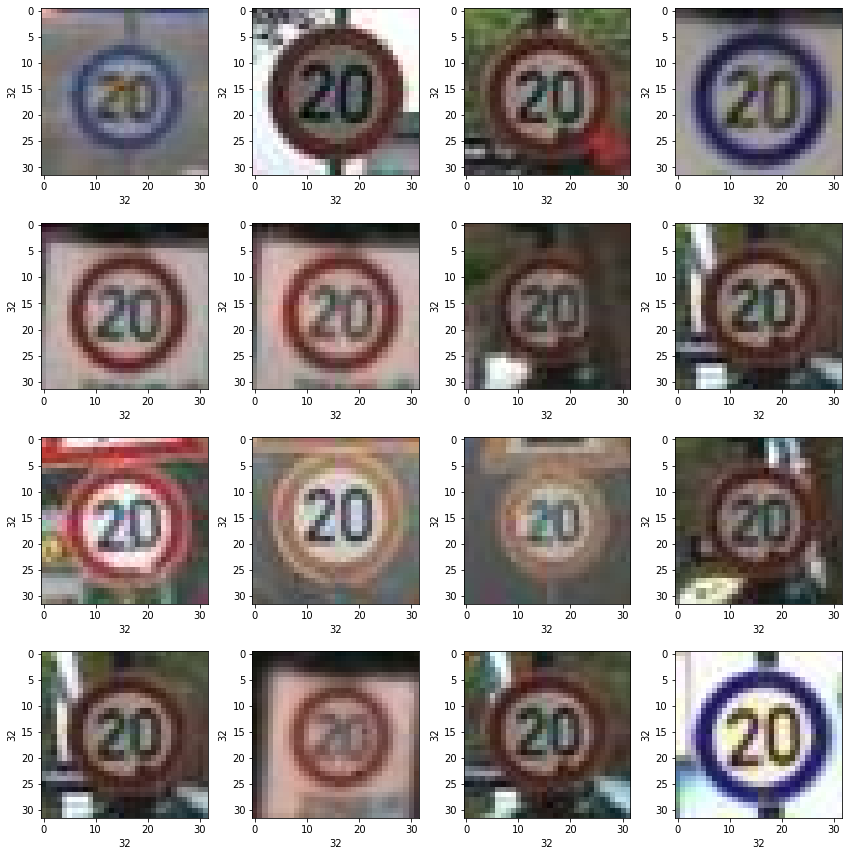

In [13]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "data/image_dataset1/0"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [14]:
# As size of images are different we have to make them equal so we will take mean of dimanesions
dim1 = []
dim2 = []
images = []
label_id = []

for i in range(0,43):
    labels = 'data/image_dataset1' + '/'+str(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])
        img = np.array(img)
        images.append(img)
        label_id.append(i)

In [15]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  32.0  Dimension 2 Mean :  32.0


In [16]:
label_id = np.array(label_id)
label_id.shape

(73139,)

In [17]:
images = np.array(images)
images.shape

(73139, 32, 32, 3)

In [18]:
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

1     4920
13    4080
12    3990
38    3930
10    3810
dtype: int64

In [19]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

In [20]:
#keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [21]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

2021-11-19 13:27:46.712691: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-19 13:27:46.714446: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [22]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [12]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Train on 58511 samples, validate on 14628 samples
Epoch 1/10
58511/58511 - 306s - loss: 4.4893 - accuracy: 0.0603 - val_loss: 3.5916 - val_accuracy: 0.0683
Epoch 2/10
58511/58511 - 305s - loss: 3.5562 - accuracy: 0.0670 - val_loss: 3.5201 - val_accuracy: 0.0683
Epoch 3/10
58511/58511 - 306s - loss: 3.5121 - accuracy: 0.0670 - val_loss: 3.4933 - val_accuracy: 0.0683
Epoch 4/10
58511/58511 - 301s - loss: 3.4963 - accuracy: 0.0670 - val_loss: 3.4835 - val_accuracy: 0.0683
Epoch 5/10
58511/58511 - 305s - loss: 3.4906 - accuracy: 0.0670 - val_loss: 3.4799 - val_accuracy: 0.0683
Epoch 6/10


KeyboardInterrupt: 

In [ ]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()